<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classification-VIT/Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Define dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classes_morepreprocess_techniques"


In [4]:
def image_generator(base_dir, batch_size=32):
    """Generate batches of images and labels from the dataset."""
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and not d.startswith('.')])
    print(f"Class Names: {class_names}")

    while True:
        images = []
        labels = []
        for label, class_name in enumerate(class_names):
            class_dir = os.path.join(base_dir, class_name)
            for file in os.listdir(class_dir):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    file_path = os.path.join(class_dir, file)
                    try:
                        # Load and preprocess image
                        image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                        image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                        images.append(image)
                        labels.append(label)

                        # Yield batch if batch size is reached
                        if len(images) == batch_size:
                            yield np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)
                            images = []
                            labels = []
                    except Exception as e:
                        print(f"[ERROR] Failed to process {file_path}: {e}")

        # Yield any remaining images in the final batch
        if images:
            yield np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)


# Define batch_size here
batch_size = 32
generator = image_generator(base_dir, batch_size)

# Fetch one batch to verify
images, labels = next(generator)
print(f"Batch loaded: {images.shape}, {labels.shape}")

Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']
Batch loaded: (32, 224, 224, 1), (32,)


In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

# Convert lists to numpy arrays
train_images = np.array(train_images)
test_images = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patches = layers.Conv2D(64, patch_size, patch_size)(inputs)
    patches = layers.Reshape((num_patches, -1))(patches)

    # Positional embedding
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=64)(tf.range(num_patches))
    x = patches + positional_embedding

    # Transformer blocks
    for _ in range(4):
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)
        ff_output = layers.Dense(128, activation='relu')(x)
        ff_output = layers.Dense(64)(ff_output)
        x = layers.Add()([x, ff_output])
        x = layers.LayerNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)  # Change this from GlobalAveragePooling1D to 2D for image data
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

In [ ]:
# Create the ViT model
input_shape = (224, 224, 1)  # Input shape for grayscale images
num_classes = len(class_names)  # Number of classes (tumor types + no tumor)
model = create_vit_model(input_shape, num_classes)  # Build the model


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Compile with Adam optimizer

# Step 3: Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=20, batch_size=32)  # Train the model

# Step 4: Evaluate the model
predictions = model.predict(test_images)  # Predict on the test set
predicted_labels = np.argmax(predictions, axis=1)  # Convert probabilities to class labels


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))  # Print detailed metrics

# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)  # Compute confusion matrix
plt.figure(figsize=(12, 10))  # Set figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)  # Plot heatmap
plt.xlabel('Predicted Labels')  # Label for x-axis
plt.ylabel('True Labels')  # Label for y-axis
plt.title('Confusion Matrix')  # Title of the plot
plt.show()  # Display the plot

In [ ]:
# Step 5: Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call to plot the metrics
plot_metrics(history)

Class Names: ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', 'meningioma', 'no tumour', 'pituitary']
Epoch 1/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 494s 687ms/step - accuracy: 0.1104 - loss: 2.7195 - val_accuracy: 0.1532 - val_loss: 2.5069
Epoch 2/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 463s 661ms/step - accuracy: 0.1845 - loss: 2.4413 - val_accuracy: 0.2426 - val_loss: 2.2542
Epoch 3/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 465s 663ms/step - accuracy: 0.2503 - loss: 2.2285 - val_accuracy: 0.3130 - val_loss: 2.0267
Epoch 4/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 464s 662ms/step - accuracy: 0.3896 - loss: 1.8558 - val_accuracy: 0.4704 - val_loss: 1.6041
Epoch 5/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 466s 665ms/step - accuracy: 0.5013 - loss: 1.5384 - val_accuracy: 0.5971 - val_loss: 1.2428
Epoch 6/20
701/701 ━━━━━━━━━━━━━━━━━━━━ 472s 673ms/step - accuracy: 0.5855 - loss: 1.2800 

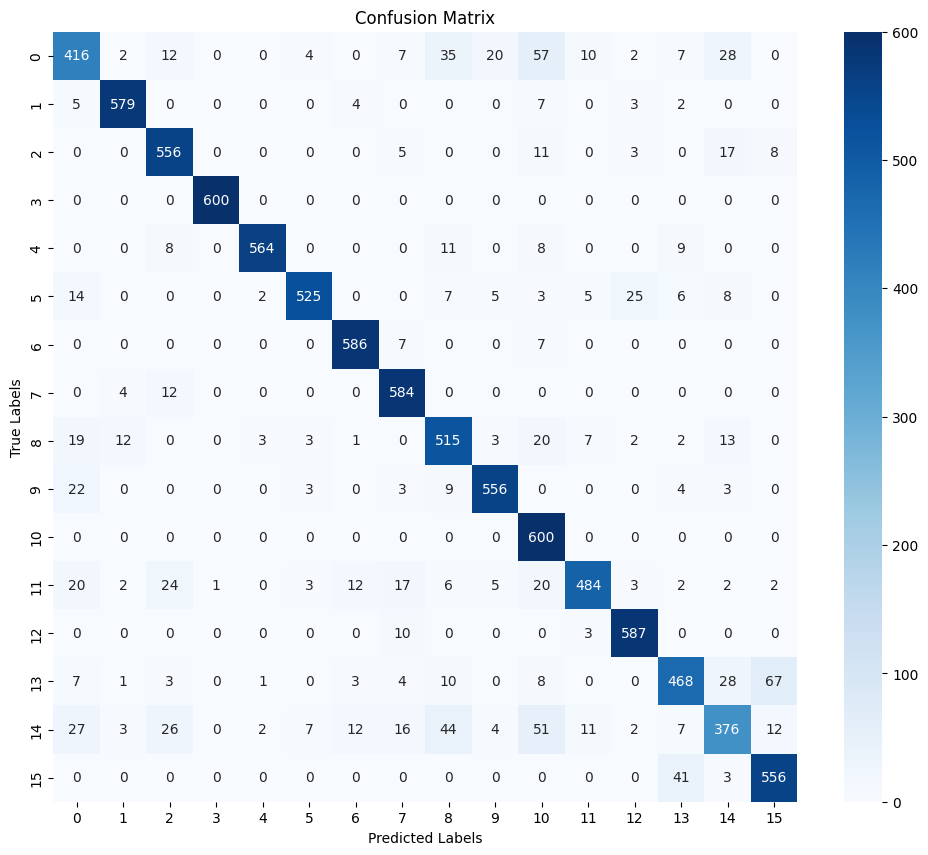

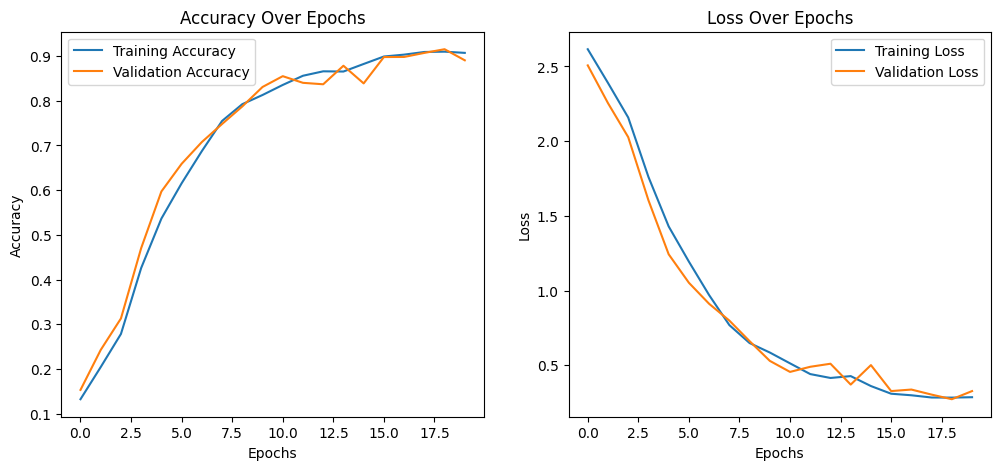

In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset directory
base_dir = "/content/drive/MyDrive/Colab Notebooks/Preprocessed_Dataset_classes_morepreprocess_techniques"

def load_dataset(base_dir):
    """Load the entire dataset into memory."""
    images = []
    labels = []
    class_names = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d)) and not d.startswith('.')])
    print(f"Class Names: {class_names}")

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(base_dir, class_name)
        for file in os.listdir(class_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, file)
                try:
                    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"[ERROR] Failed to process {file_path}: {e}")

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# Load the dataset
images, labels = load_dataset(base_dir)

# Split data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

def create_vit_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    patches = layers.Conv2D(64, patch_size, patch_size)(inputs)
    patches = layers.Reshape((num_patches, -1))(patches)

    # Positional embedding
    positional_embedding = layers.Embedding(input_dim=num_patches, output_dim=64)(tf.range(num_patches))
    x = patches + positional_embedding

    # Transformer blocks
    for _ in range(4):
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)
        ff_output = layers.Dense(128, activation='relu')(x)
        ff_output = layers.Dense(64)(ff_output)
        x = layers.Add()([x, ff_output])
        x = layers.LayerNormalization()(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

# Create the ViT model
input_shape = (224, 224, 1)  # Input shape for grayscale images
num_classes = len(np.unique(labels))  # Number of classes (tumor types + no tumor)
model = create_vit_model(input_shape, num_classes)  # Build the model

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=20, batch_size=32)

# Evaluate the model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

# Confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call to plot the metrics
plot_metrics(history)
